## Binarni Genetski Algoritam ##




*   Binarni genetski algoritam
*   Jednotačkasto i dvotačkasto ukrštanje
*   Mutacija inverzijom i rotacijom
*   Primeri: sferna i Levijeva funkcija

**Postupak genetskog algoritma:** </br>
START
<br>
Inicijalizacija početne populacije
<br>
Računanje funkcije prilagođenosti
<br>
Ponavljati: <br>

*   Selekciju
*   Ukrštanje
*   Mutaciju
*   Računanje funkcije prilagođenosti

DOK populacija ne iskonvergira <br>
STOP<br>


# 1. Biblioteke

Prvo je neophodno učitati python biblioteke:

In [1]:
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt
import math

from mpl_toolkits import mplot3d

pi = 3.1415

# 2. Funkcija za kodiranje i dekodiranje hromozoma

Prvo je neophodno jedinku kodirati u odgovarajućoj formi, zavisno od implementacije GA algoritma koji se koristi. U ovom slučaju je neophodno predstaviti je u binarnom obliku.
Da bismo predstavili realnu vrednost u obliku binarnog broja potrebno je da definišemo preciznost, tj broj bita registra u $n$. Broj različitih vrednost koji se može predstaviti sa tim broj bita je $2^n$, najmanja vrednosti $0$ dok je najveća $2^n -1$.

Nivo diskretizacije
\begin{equation}
\Delta=\frac{opseg}{2^n}
\end{equation}
pri tome greška koja nastaje je:
\begin{equation}
error=\frac{\Delta}{2}
\end{equation}

In [2]:
def bin_encode(chromosome, bin_val, min_val, precision):
 #chromosome- vrednost jedne koordinate, nor realna vrednost
 # bin_val- nivo diskretizacije  
 # max_val- minimalnu  vrednost opsega  
 # precision- broj bita za predstavljanje svakog broja
  
  ret = ""
  for g in chromosome:
    val = round((g - min_val)/bin_val)  
    ret += bin(val)[2:].rjust(precision,'0') # transformisemo u binarni broj    
  return ret

def bin_encode_chromosomes(chromosomes, precision, max_val, min_val):
  #chromosomes- ili jedinka 
  # precision- broj bita za predstavljanje svakog broja
  # max_val, min_val- definišemo maksimalnu i minimalnu  vrednost opsega  
  bin_val = (max_val - min_val) / (2**precision-1)  # nivo diskretizicije
  # za svaki hromozom unutar jedinke (npr i za x i y vrednost) pretvaramo u binarni broj
  bin_chromosomes = [ bin_encode(c, bin_val, min_val, precision) for c in chromosomes]
  return bin_chromosomes

In [3]:
bin_encode_chromosomes([[2, 3]],10,0,10) # test

['11001100101011001100']

## Dekodiranje jedinke
Vraćanje binarno kodirane jedinke u vrednost realnog broja koja odgovara tako kodiranoj jedincki

In [4]:
def bin_decode(chromosome, bin_val, min_val, precision):

  ret = []
  for idx in range(0, len(chromosome), precision):
    g = int(chromosome[idx:idx + precision], 2)
    ret.append(g * bin_val + min_val)
    
  return ret

def bin_decode_chromosomes(chromosomes, precision, max_val, min_val):
  
  bin_val = (max_val - min_val) / (2**precision-1) 

  bin_chromosomes = [ bin_decode(c, bin_val, min_val, precision) for c in chromosomes]
  return bin_chromosomes


In [5]:
bin_decode_chromosomes(['11001100101011001100'],10,0,10)

[[2.0039100684261975, 3.0009775171065494]]

# 3. Generisanje populacije
**Početna populacija**

GA započinjemo kreiranjem skupa jedinki koji se naziva populacijom. Svaka jedinka predstavlja potencijalno rešenje.

In [6]:
def generate_inital_chromosomes(length, max, min, pop_size):
  return [ [random.uniform(min,max) for j in range(length)] for i in range(pop_size)]

def population_stats(costs):
  return costs[0], sum(costs)/len(costs)

# 4. Funkcije za rangiranje i **selekciju** jedinki

Jedinke se rangiraju (sortiraju) po vrednosti funkcije prilagođenosti funkcijom **rank_chromosomes**.</br>
Implementirane su sledece vrste selekcija: prirodna i ruletska selekcija. </br>
Prirodna selekcija je implementirana u  funkciji **natural_selection**, pri čemu ostavljamo samo prvih *n_keep* jedinki.</br>
Funkcija **roulette_selection** predstavlja ruletski tip selekcije.

In [7]:
def rank_chromosomes(cost, chromosomes):
  costs = list(map(cost, chromosomes))
  ranked  = sorted( list(zip(chromosomes,costs)), key = lambda c:c[1])
  
  return list(zip(*ranked))

def natural_selection(chromosomes, n_keep):
  return chromosomes[:n_keep]

def roulette_selection(parents):

  pairs = []
  i = 0
  for i in range(0, len(parents), 2):

    weights=[];
    for i in range(len(parents)):
        weights.append((len(parents)-i)*random.random()) #za minimum
      #  weights.append((i+1)*random.random()) #za maksimum
    if (weights[0]>=weights[1]):
        maxInd1=0;
        maxInd2=1;
    else:
        maxInd1=1;
        maxInd2=0;
    
    for i in range(2,len(parents)):
        if weights[i]>weights[maxInd1]:
            maxInd2=maxInd1
            maxInd1=i
        elif weights[i]>weights[maxInd2]:
            maxInd2=1
    pairs.append([parents[maxInd1], parents[maxInd2]])
      
  return pairs

# 5. Funkcije za  ukrštanje

## Funkcija za jednotačkasto ukrštanje
Nasumično biramo jednu tačku ukrštanja. Novi hromozomi h3, h4 će biti sastavljeni od delova ulaznih hromozoma (h1, h2). I to na sledeći način:

* h3 dobija genetski materijal od h1 od početka do  presečne tačke a genetski materijal od h2 dobija od presečne tačke do KRAJA


* h4 dobija genetski materijal od h2 od početka do  presečne tačke a genetski materijal od h1 dobija od presečne tačke do KRAJA

In [8]:
def one_point_crossover(pairs):
  length = len(pairs[0])
  children = []
  
  for (a,b) in pairs:  
   
      r = random.randrange(0, length)
    
      children.append(a[:r] + b[r:])
      children.append(b[:r] + a[r:] )
    
  return children  

## Funkcija za dvotačkasto ukrštanje
Nasumično biramo dve tačke ukrštanja. Novi hromozomi h3, h4 će biti sastavljeni od delova ulaznih hromozoma (h1, h2). I to na sledeći način:

* h3 dobija genetski materijal od h1 od početka do prve presečne tačke T1 i od druge presečne tačke T2 do KRAJA 
a genetski materijal od h2 dobija od prve do druge presečne tačke


* h4 dobija genetski materijal od h2 od početka do prve presečne tačke i od druge presečne tačke do kraja 
a genetski materijal od h1 dobija od prve do druge presečne tačke

In [9]:
def two_point_crossover(pairs):
  length = len(pairs[0])
  children = []
  
  for (a,b) in pairs:  
   
      r1 = random.randrange(0, length)
      r2 = random.randrange(0, length)
      
      if r1 < r2:
        children.append(a[:r1] + b[r1:r2] + a[r2:])
        children.append(b[:r1] + a[r1:r2] + b[r2:])
      else:
        children.append(a[:r2] + b[r2:r1] + a[r1:])
        children.append(b[:r2] + a[r2:r1] + b[r1:])
    
  return children 

# 6. Mutacija 

# Mutacija inverzijom

Nasumično biramo dve  tačke u hromozomu i genetski materijal koji se nalazi između te dve tačke invertujemo.



> primer: h = [ 1110101000 ]
<br>nasumično izabrani indeksi: r1 = 3, r2 = 6
<br>rezultat nakon mutacije: [1111010000]

In [10]:
def inv_mutation(chromosomes, mutation_rate):
  mutated_chromosomes = []
  
  for chromosome in chromosomes:
    
    if random.random() < mutation_rate:
      r1 = random.randrange(0, len(chromosome) - 1)
      r2 = random.randrange(0, len(chromosome) - 1)
      
      if r1 < r2:
        mutated_chromosomes.append(chromosome[:r1] + chromosome[r1:r2][::-1] + chromosome[r2:])
      else:
        mutated_chromosomes.append(chromosome[:r2] + chromosome[r2:r1][::-1] + chromosome[r1:])
        
    else:
      mutated_chromosomes.append(chromosome)
      

  return mutated_chromosomes

In [11]:
inv_mutation(['11001100101011001100'], 0.7)

['11010100110011001100']

## Mutacija rotacijom

Nasumično biramo jednu tačku u hromozomu i genetski materijal koji se nalazi u toj tački invertujemo.

primer: h = [ 1110101000 ]
nasumično izabrani indeksi: r1 = 3
rezultat nakon mutacije:  [ 1111101000 ]

In [12]:
def mutation(chromosomes, mutation_rate):
  mutated_chromosomes = []  
  for chromosome in chromosomes: 

    if random.random() < mutation_rate:
      r1 = random.randrange(0, len(chromosome) - 1)         
      mutated_chromosomes.append( chromosome[:r1]+ str (1-int(chromosome[r1]))+ chromosome[r1+1:]    )        
    else:
      mutated_chromosomes.append(chromosome)
      

  return mutated_chromosomes

In [13]:
mutation(['11001100101011001100'], 0.9)

['11001100101010001100']

# Elitizam

Elitizam omogućava prenos najbolje prilagođenih jedinki iz stare generacije u novu.

In [14]:
def elitis(chromosomes_old,chromosomes_new, elitis_rate, population_size):
 
  old_ind_size=int(np.round(population_size*elitis_rate))
  return chromosomes_old[:old_ind_size]+chromosomes_new[:(population_size-old_ind_size)]
  


# 7. Definicija  funkcije

Definisaćemo funkciju kojoj tražimo optimum (minimum). 

##  Primer 1: Sfera funkcija 

Kao prvi primer koristićemo sfernu funkciju koja se definiše na sledeći način


\begin{equation}
f(x, y) = x^2 +y ^2 \\
\mbox{interval: }  -10 < x, y < 10,\\
\mbox{minimum: } f(0,0) = 0 
\end{equation}

##  Primer 2: Levijeva funkcija 
Kao drugi primer koristićemo Levijevu funkciju koja se definiše na sledeći način


\begin{equation}
f(x, y) = sin^2 3πx + (x − 1)^2(1 + sin^2 3πy) + (y − 1)^2(1 + sin^2 2πy) \\
 \mbox{interval: } -10 < x, y < 10,\\
  \mbox{minimum: } f(1,1) = 0 
\end{equation}

In [15]:
def sphera_function(chromosome):
  x = chromosome[0]
  y = chromosome[1] 
  
  tmp1 = math.pow(x, 2)
  tmp2 = math.pow(y, 2)


  return tmp1 + tmp2 

In [16]:
def levy_function(chromosome):
  x = chromosome[0]
  y = chromosome[1] 
  
  tmp1 = math.pow(math.sin(3*pi*x), 2)
  tmp2 = math.pow((x - 1), 2) * (1 + math.pow(math.sin(3*pi*y), 2))
  tmp3 = math.pow((y - 1), 2) * (1 + math.pow(math.sin(2*pi*y), 2))

  return tmp1 + tmp2 + tmp3

# 7.1. 3D Prikaz funkcije

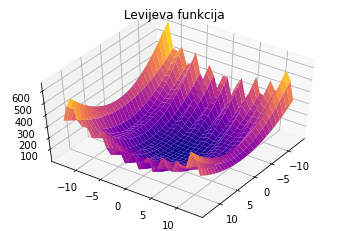

In [17]:
def l_show(x, y):
  tmp1 = math.pow(math.sin(3*pi*x), 2)
  tmp2 = math.pow((x - 1), 2) * (1 + math.pow(math.sin(3*pi*y), 2))
  tmp3 = math.pow((y - 1), 2) * (1 + math.pow(math.sin(2*pi*y), 2))

  return tmp1 + tmp2 + tmp3

def s_show(x, y):  
  tmp1 = math.pow(x, 2)
  tmp2 = math.pow(y, 2)
  return tmp1 + tmp2 

levy_vectorized = np.vectorize(l_show)

x = np.linspace(-13, 13, 30)
y = np.linspace(-13, 13, 30)

X, Y = np.meshgrid(x, y)
Z = levy_vectorized(X, Y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='plasma', edgecolor='none')
ax.set_title('Levijeva funkcija');

ax.view_init(50, 35)

# 8. Main loop - sklopljen genetski algoritam
- Generišemo početnu populaciju veličine *population_size* 
- Vrtimo glavnu petlju maksimalno *max_iter* puta, pri čemu svaka iteracija petlje predstavlja jednu generaciju
- Rangiramo jedinke po prilagođenosti, funkcijom **rank_chromosomes**
- Funkcijom **natural_selection** biramo roditelje (ovo je visak)
- Funkcijom **bin_encode_chromosomes** kodiramo celu roditeljsku populaciju
- Funkcijom **roulette_selection** odvajamo parove roditeljskih hromozoma koje ćemo ukrstiti 
- Metodom *dvotačkastog ukrštanja*, tj funkcijom **two_point_crossover** uparujemo roditeljske hromozome i dobijemo populaciju dece
- Spajamo novonastale hromozome sa roditeljskim u novu populaciju *chromosomes* 
- Na ovoj populaciji vršimo *inverznu mutaciju* funkcijom **inv_mutation** sa zadatim *mutation_rate = 0.3*
- Dekodiramo celu populaciju funkcijom **bin_decode_chromosomes**
- Proveravamo da li populacija konvergira ili da li smo došli do optimalnog rešenja
- Ispisujemo statistike za svaku generaciju: prosečna prilagođenost, najbolji hromozom i sastav najboljeg hromozoma

In [18]:
def genetic(cost_func , extent, population_size, mutation_rate = 0.8,elitis_rate=0.1, chromosome_length = 2, precision = 13, max_iter = 500):

  min_val = extent[0]
  max_val = extent[1]

  
  avg_list = []
  best_list = []
  curr_best = 10000
  same_best_count = 0
  
  chromosomes = generate_inital_chromosomes(chromosome_length, max_val, min_val, population_size)

  for iter in range(max_iter):
      
    ranked_parents, costs = rank_chromosomes(cost_func, chromosomes)     
    best, average = population_stats(costs)
    parents = natural_selection(ranked_parents, population_size) 
    parents = bin_encode_chromosomes(parents, precision, max_val, min_val)     

    pairs = roulette_selection (parents)       
    children = two_point_crossover(pairs)     
    chromosomes = inv_mutation(children, mutation_rate)
    chromosomes = bin_decode_chromosomes(chromosomes, precision, max_val, min_val)

    ranked_children, costs = rank_chromosomes(cost_func, chromosomes)
    chromosomes=elitis(ranked_parents,ranked_children, elitis_rate, population_size)
    print("Generation: ",iter+1," Average: {:.3f}".format(average)," Curr best: {:.3f}".format(best), 
         "[X, Y] = {:.3f} {:.3f}".format(chromosomes[0][0],chromosomes[0][1]))
    print("-------------------------")
    
    avg_list.append(average)
    if best < curr_best:
      best_list.append(best)
      curr_best = best
      same_best_count = 0
    else:
      same_best_count += 1
      best_list.append(best)
      
    ##
    if (cost_func(chromosomes[0]) < 0.05):
      
      avg_list = avg_list[:iter]
      best_list = best_list[:iter]
      all_avg_list.append(avg_list)
      all_best_list.append(best_list)
      generations_list.append(iter)
     
      print("\nSolution found ! Chromosome content: [X, Y] = {:.3f} {:.3f}\n".format(chromosomes[0][0],chromosomes[0][1]))
      return
        
    if same_best_count > 20:
      print("\nStopped due to convergance.Best chromosome [X, Y] = {:.3f} {:.3f}\n".format(chromosomes[0][0],chromosomes[0][1]))
      
      avg_list = avg_list[:iter]
      best_list = best_list[:iter]
      all_avg_list.append(avg_list)
      all_best_list.append(best_list)
      generations_list.append(iter)
      
      return
    
    if iter == 499:
      avg_list = avg_list[:iter]
      best_list = best_list[:iter]
      all_avg_list.append(avg_list)
      all_best_list.append(best_list)
      generations_list.append(iter)
      
      print("\nStopped due to max number of iterations, solution not found. Best chromosome [X, Y] = {:.3f} {:.3f}\n".format(chromosomes[0][0],chromosomes[0][1]))

# 9. Iscrtavanje grafikona</br>
Iscrtavamo prosečnu i najbolji prilagođenost za svaku generaciju.

In [19]:
def display_stats(all_avg_list, all_best_list, generations_list):
  
  c = 0
  colors = ['red', 'green', 'blue', 'yellow', 'orange']
  
  for average_list in all_avg_list:
      x_axis = list(range(generations_list[c]))
      y_axis = average_list
      plt.plot(x_axis, y_axis, linewidth=3, color=colors[c], label=str(c + 1))
      plt.title('Average cost function value', fontsize=19)
      plt.xlabel('Generation', fontsize=10)
      plt.ylabel('Cost function')
      c += 1
  plt.legend(loc='upper right')
  plt.show()

  c = 0

  for best_list in all_best_list:
      x_axis = list(range(generations_list[c]))
      y_axis = best_list
      plt.plot(x_axis, y_axis, color=colors[c], label=str(c + 1))
      plt.title('Best cost function value', fontsize=19)
      plt.xlabel('Generation')
      plt.ylabel('Cost function')
      c += 1
  plt.legend(loc='upper right')
  plt.show()

# 10. Konfigurisanje i poziv genetskog algoritma

Argumenti funkcije:


1.   Funkcija za minimizaciju (u našem slučaju Levy_function) - *function*
2.   Opseg u kome pretražujemo rešenje - *list*
3.   Broj hromozoma (jedinki) - *int*


---

Opcioni argumenti:


4.   Stopa mutacije - *float*
5.   Dužina hromozoma - *int*
6.   Na koliko decimala kodujemo X i Y - *int*
7.   Maksimalni broj iteracija - *int*


 1 : run of genetic algorithm with  20  chromosomes.

Generation:  1  Average: 119.883  Curr best: 24.009 [X, Y] = -3.083 -0.389
-------------------------
Generation:  2  Average: 48.477  Curr best: 5.586 [X, Y] = 2.900 1.967
-------------------------
Generation:  3  Average: 24.026  Curr best: 5.586 [X, Y] = 2.900 1.967
-------------------------
Generation:  4  Average: 12.374  Curr best: 5.586 [X, Y] = 2.900 1.967
-------------------------
Generation:  5  Average: 23.557  Curr best: 5.102 [X, Y] = 2.626 0.873
-------------------------
Generation:  6  Average: 17.336  Curr best: 5.102 [X, Y] = 2.626 0.873
-------------------------
Generation:  7  Average: 12.807  Curr best: 2.980 [X, Y] = 2.626 1.029
-------------------------
Generation:  8  Average: 7.979  Curr best: 2.980 [X, Y] = 2.626 1.029
-------------------------
Generation:  9  Average: 19.895  Curr best: 1.502 [X, Y] = 1.903 1.029
-------------------------
Generation:  10  Average: 14.743  Curr best: 1.073 [X, Y] = 1.977 1.0

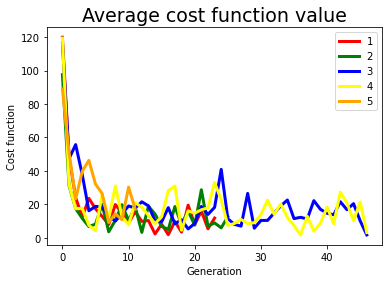

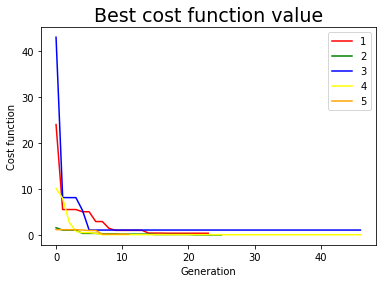


 1 : run of genetic algorithm with  100  chromosomes.

Generation:  1  Average: 97.914  Curr best: 1.096 [X, Y] = 0.341 1.568
-------------------------
Generation:  2  Average: 33.089  Curr best: 0.889 [X, Y] = 1.122 0.866
-------------------------
Generation:  3  Average: 9.062  Curr best: 0.525 [X, Y] = 1.627 1.002
-------------------------
Generation:  4  Average: 8.250  Curr best: 0.030 [X, Y] = 1.005 0.866
-------------------------

Solution found ! Chromosome content: [X, Y] = 1.005 0.866


 2 : run of genetic algorithm with  100  chromosomes.

Generation:  1  Average: 94.600  Curr best: 0.846 [X, Y] = 1.640 1.405
-------------------------
Generation:  2  Average: 24.151  Curr best: 0.846 [X, Y] = 1.640 1.405
-------------------------
Generation:  3  Average: 19.519  Curr best: 0.846 [X, Y] = 1.640 1.405
-------------------------
Generation:  4  Average: 13.280  Curr best: 0.846 [X, Y] = 1.640 1.405
-------------------------
Generation:  5  Average: 15.512  Curr best: 0.846 [X, 

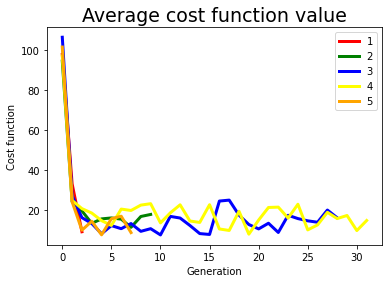

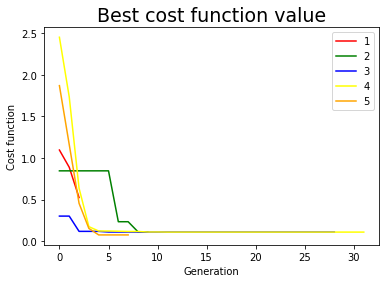


 1 : run of genetic algorithm with  150  chromosomes.

Generation:  1  Average: 95.404  Curr best: 2.281 [X, Y] = 1.961 1.720
-------------------------
Generation:  2  Average: 43.246  Curr best: 1.835 [X, Y] = -0.006 0.773
-------------------------
Generation:  3  Average: 48.546  Curr best: 1.315 [X, Y] = 0.953 0.248
-------------------------
Generation:  4  Average: 27.492  Curr best: 0.456 [X, Y] = 0.953 0.482
-------------------------
Generation:  5  Average: 17.713  Curr best: 0.443 [X, Y] = 0.953 0.492
-------------------------
Generation:  6  Average: 14.396  Curr best: 0.186 [X, Y] = 0.953 0.951
-------------------------
Generation:  7  Average: 17.659  Curr best: 0.002 [X, Y] = 0.997 0.961
-------------------------

Solution found ! Chromosome content: [X, Y] = 0.997 0.961


 2 : run of genetic algorithm with  150  chromosomes.

Generation:  1  Average: 109.568  Curr best: 1.000 [X, Y] = 1.267 0.378
-------------------------
Generation:  2  Average: 25.384  Curr best: 0.607 

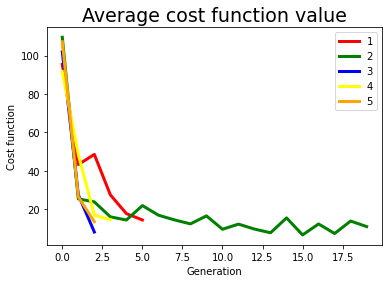

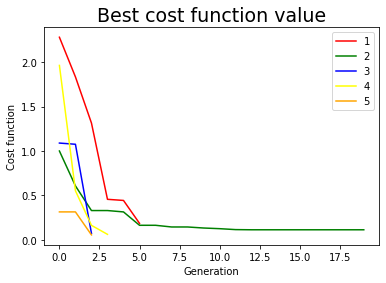

In [20]:
number_of_chromosomes = [20, 100, 150]
all_avg_list = []
generations_list = []
all_best_list = []
run_number = 5

for x in number_of_chromosomes:
  
  print("==========================")
  
  for k in range(0, run_number):
    
    print("\n", k + 1, ": run of genetic algorithm with ", x ," chromosomes.\n")    
    genetic(levy_function, [10, -10], x)
    
  display_stats(all_avg_list, all_best_list, generations_list)
  all_best_list = []
  all_avg_list = []
  generations_list = []